In [0]:

!wget -P /root/input/ -c "http://nlp.stanford.edu/data/glove.6B.zip"

--2020-03-12 09:01:31--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-03-12 09:01:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-03-12 09:01:31--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/root/input/glove.6B.z

In [0]:
import tensorflow as tf
from tensorflow import keras
import os
import re
import pandas as pd


def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)
  
  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
  
  return train_df, test_df

train,test = download_and_load_datasets()

84131840/84125825 [==============================] - 8s 0us/step


In [0]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from keras.models import Model, Sequential
from keras.initializers import Constant

MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000 
EMBEDDING_DIM = 100 
VALIDATION_SPLIT = 0.2


In [0]:
train.columns

Index(['sentence', 'sentiment', 'polarity'], dtype='object')

In [0]:
train_texts = train['sentence'].values
train_labels = train['polarity'].values
test_texts = test['sentence'].values
# test_labels = test['polarity'].values

labels_index = {'pos':1, 'neg':0} 

In [0]:
test.columns


Index(['sentence', 'sentiment', 'polarity'], dtype='object')

In [0]:
test_labels = test['polarity'].values
test_labels

array([1, 0, 1, ..., 0, 0, 0])

(20000, 1000)

In [0]:
print("Defining and training an LSTM model, training embedding layer on the fly")


Defining and training an LSTM model, training embedding layer on the fly


In [0]:
vocab_size = 20000  # Max number of different word, i.e. model input dimension
maxlen = 1000 # Max number of words kept at the end of each text

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.pipeline import TransformerMixin
from sklearn.base import BaseEstimator

class TextsToSequences(Tokenizer, BaseEstimator, TransformerMixin):
    """ Sklearn transformer to convert texts to indices list 
    (e.g. [["the cute cat"], ["the dog"]] -> [[1, 2, 3], [1, 4]])"""
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)
        
    def fit(self, texts, y=None):
        self.fit_on_texts(texts)
        return self
    
    def transform(self, texts, y=None):
        return np.array(self.texts_to_sequences(texts))
        
sequencer = TextsToSequences(num_words=vocab_size)




class Padder(BaseEstimator, TransformerMixin):
    """ Pad and crop uneven lists to the same length. 
    Only the end of lists longernthan the maxlen attribute are
    kept, and lists shorter than maxlen are left-padded with zeros
    
    Attributes
    ----------
    maxlen: int
        sizes of sequences after padding
    max_index: int
        maximum index known by the Padder, if a higher index is met during 
        transform it is transformed to a 0
    """
    def __init__(self, maxlen=500):
        self.maxlen = maxlen
        self.max_index = None
        
    def fit(self, X, y=None):
        self.max_index = pad_sequences(X, maxlen=self.maxlen).max()
        return self
    
    def transform(self, X, y=None):
        X = pad_sequences(X, maxlen=self.maxlen)
        X[X > self.max_index] = 0
        return X

padder = Padder(maxlen)



In [0]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional, LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import make_pipeline

batch_size = 64
max_features = vocab_size + 1

def create_model(max_features):
    """ Model creation function: returns a compiled LSTM"""


    rnnmodel = Sequential()
    rnnmodel.add(Embedding(MAX_NUM_WORDS, 128))
    rnnmodel.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    rnnmodel.add(Dense(1, activation='sigmoid'))
    rnnmodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return rnnmodel


# Use Keras Scikit-learn wrapper to instantiate a LSTM with all methods
# required by Scikit-learn for the last step of a Pipeline
sklearn_lstm = KerasClassifier(build_fn=create_model, epochs=2, batch_size=32, 
                               max_features=max_features, verbose=1)

# Build the Scikit-learn pipeline
pipeline = make_pipeline(sequencer, padder, sklearn_lstm)

pipeline.fit(train_texts, train_labels);

Epoch 1/2
25000/25000 [==============================] - 1486s 59ms/step - loss: 0.5025 - acc: 0.7597
Epoch 2/2
25000/25000 [==============================] - 1475s 59ms/step - loss: 0.3441 - acc: 0.8572


In [0]:
from sklearn import metrics
print('Computing predictions on test set...')
y_preds = pipeline.predict(test_texts)




Computing predictions on test set...
25000/25000 [==============================] - 312s 12ms/step


ValueError: ignored

In [0]:
print('Test accuracy: {:.2f} %'.format(100*metrics.accuracy_score(y_preds, test_labels)))

Test accuracy: 83.70 %


Sample 11: last 1000 words (only part used by the model)
--------------------------------------------------
The film starts out with a narration of the protagonist explaining certain crimes occurring all over the city and then we get to know that the hero is a cop who is either suspended or has probably retired. I did not have the patience or the interest to verify the above before commenting. If there is a stereotype for narrators to have a deep, sleep-inducing voice then, it is high time to put an end to it. I seriously fell asleep and did not bother to shut the movie down either. Am still trying to figure out what the movie was all about and why there were no outdoor shootings. A third rate TV Serial will have more number of sets compared to this crap of a movie and I still pity the actors and producers involved in this huge bullshit of a movie. It ought to have been produced as a normal TV serial or maybe even as a local theater drama instead of putting it out on the big screen. To

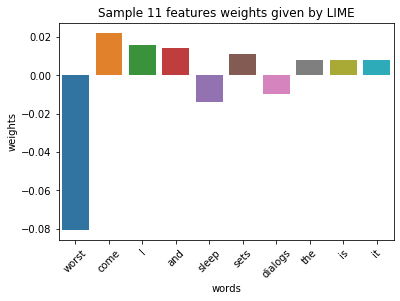

In [0]:


# We choose a sample from test set
idx = 11
text_sample = test_texts[idx]
class_names = ['negative', 'positive']

print('Sample {}: last 1000 words (only part used by the model)'.format(idx))
print('-'*50)
print(" ".join(text_sample.split()[-1000:]))
print('-'*50)
print('Probability(positive) =', pipeline.predict_proba([text_sample])[0,1])
print('True class: %s' % class_names[test_labels[idx]])



import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import OrderedDict
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=class_names)
explanation = explainer.explain_instance(text_sample, pipeline.predict_proba, num_features=10)

weights = OrderedDict(explanation.as_list())
lime_weights = pd.DataFrame({'words': list(weights.keys()), 'weights': list(weights.values())})

sns.barplot(x="words", y="weights", data=lime_weights);
plt.xticks(rotation=45)
plt.title('Sample {} features weights given by LIME'.format(idx));